# To BLT or to still BPE - that is here the question

Let's dig into Machine Learning for Log Analysis, specifically on 

* tokenization with byte-pair encoding (BPE) or byte latent transformation (BLT)

We will use *Linformer* (also Meta research) as a model to create compareable log vector representations (same parameters). 

We evaluate the embeddings based on common model metrics. Linformer has the advantage that it uses O(n) for both memory and computation time, which in case of logs is key given the potencial volume and throughput. The expected length of Byte-Pair-Encoding (BPE) vs. Byte-Latent-Transformation (BLT) tokens is 8-16 times longer. Therefore a Deep Learning model that has an Attention mechanism with linear complexity is ideal for log analysis.

Note: this is research level code.

## Loading the sample dataset

The following dataset is a contribution from my thesis. It contains Sysmon traces of malicicous MS-XLS (Excel) documents aka Macro Malware. 

Note: In this Jupyter notebook we are not concerned about the classfication, but rather the vector representation. The dataset is reused for practical experiments.

### Load a cleaned dataset

In [1]:
from pathlib import Path

def get_json_file_path():
    # Define the file path
    json_path = Path(r"C:\Users\mariu\source\datasets\log2ml\lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_clean.json")
    
    # Check if the file exists
    if json_path.exists():
        return json_path
    else:
        raise FileNotFoundError(f"The JSON file does not exist at: {json_path}")

In [2]:
json_path = ""
try:
    json_file_path = get_json_file_path()
    print(f"JSON file found at: {json_file_path}")
except FileNotFoundError as e:
    print(e)

JSON file found at: C:\Users\mariu\source\datasets\log2ml\lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_clean.json


### Load the config

The `config.json` is in the .gitignore file. It simply contains the huggingface token (key: `huggingface_token`).

In [3]:
import json
with open('config.json', 'r') as f:
    config = json.load(f)
hf_token = config['huggingface_token']

## BLT with Llama 2, and an untrained BPE tokenizer

We are not training the tokenizers. Instead here we use them as generic pre-processors. You can train a BPE tokenizer instead, depending on the chosen format. They can be used for JSON or text files (like Syslog).

*Llama 3* is supported as well, but that's for later.

## The Lllama has...

The following code initializes the tokenizers. In case of the BLT tokenizer, we need to initialte *Llama* first. We do this via the Huggingface Hub. In order to be able to do this, you need to accept Meta's license. This is a quick process, and usually takes 5 minutes for *Llama 2* and for *Llama 3*.

In [2]:
import os
from huggingface_hub import hf_hub_download
import json

# Load HF token from config
with open('config.json', 'r') as f:
    config = json.load(f)
    hf_token = config.get("huggingface_token")

# Llama2 tokenizer details from the setup script
repo_id = "meta-llama/Llama-2-7b"
filename = "tokenizer.model"
path_to_save = "./tokenizers"  # You can change this path as needed

# Download the tokenizer
output_path = hf_hub_download(
    repo_id=repo_id,
    filename=filename,
    local_dir=path_to_save,
    local_dir_use_symlinks=False,
    token=hf_token
)

print(f"Successfully downloaded tokenizer to: {output_path}")

c:\Users\mariu\anaconda3\envs\log2ml\Lib\site-packages\huggingface_hub\file_download.py:834: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Successfully downloaded tokenizer to: tokenizers\tokenizer.model


## The path of the dataset

This has just been created on a *Windows 11 Pro* system.

In [3]:
import sys
import os
from pathlib import Path

# Add the BLT directory to Python path
blt_dir = Path(r"c:/Users/mariu/source/projects/infosec_ml_rnd/bpe_vs_blt_log_vec/blt")
sys.path.append(str(blt_dir))

# Now you can import bytelatent
from bytelatent.tokenizers.blt_tokenizer import BltTokenizer
from bytelatent.tokenizers.sentence_piece_tokenizer import SentencePieceTokenizer

# Test the imports
print("BLT imports successful!")

BLT imports successful!


In [4]:
# Initialize tokenizers
tokenizer_path = Path("tokenizers/tokenizer.model")  # Path where we downloaded the tokenizer

try:
    bpe_tokenizer = SentencePieceTokenizer(model_path=str(tokenizer_path))
    blt_tokenizer = BltTokenizer(
        bpe_delim=True,
        bpe_tokenizer_path=str(tokenizer_path),
        add_bos=True,
        add_eos=True
    )
    print("Tokenizers initialized successfully!")
    
    # Test with a simple string
    test_text = "Hello, this is a test."
    bpe_tokens = bpe_tokenizer.encode(test_text)
    blt_tokens = blt_tokenizer.encode(test_text)
    
    print(f"\nTest results:")
    print(f"Original text: {test_text}")
    print(f"BPE tokens: {bpe_tokens}")
    print(f"BLT tokens: {blt_tokens}")
    
except Exception as e:
    print(f"Error initializing tokenizers: {e}")

Tokenizers initialized successfully!

Test results:
Original text: Hello, this is a test.
BPE tokens: [1, 15043, 29892, 445, 338, 263, 1243, 29889, 2]
BLT tokens: [1, 3, 76, 105, 112, 112, 115, 3, 48, 3, 36, 120, 108, 109, 119, 3, 36, 109, 119, 3, 36, 101, 3, 36, 120, 105, 119, 120, 3, 50, 2]


As we see the BLT tokenizer output is much longer. 

In [5]:
# Let's decode the BPE tokens to see what each number represents
print("BPE token meanings:")
for token in bpe_tokens:
    piece = bpe_tokenizer.sp_model.id_to_piece(token)
    print(f"Token {token} -> '{piece}'")

BPE token meanings:
Token 1 -> '<s>'
Token 15043 -> '▁Hello'
Token 29892 -> ','
Token 445 -> '▁this'
Token 338 -> '▁is'
Token 263 -> '▁a'
Token 1243 -> '▁test'
Token 29889 -> '.'
Token 2 -> '</s>'


In [6]:
# Test with our original text
test_text = "Hello, this is a test."
print(f"Original text: {test_text}")

# Get BPE tokens and show their meanings
bpe_tokens = bpe_tokenizer.encode(test_text)
print("\nBPE token meanings:")
for token in bpe_tokens:
    piece = bpe_tokenizer.sp_model.id_to_piece(token)
    print(f"Token {token} -> '{piece}'")

# Get BLT tokens and show their meanings
blt_tokens = blt_tokenizer.encode(test_text)
print("\nBLT token meanings:")
# Use the proper decode method
decoded_text = blt_tokenizer.decode(blt_tokens)
print(f"\nBLT tokens: {blt_tokens}")
print(f"BLT decoded text: {decoded_text}")

# If you want to see individual bytes:
print("\nBLT token meanings (byte-level):")
for token in blt_tokens:
    if token == blt_tokenizer.bos_id:
        print(f"Token {token} -> BOS (Beginning of Sequence)")
    elif token == blt_tokenizer.eos_id:
        print(f"Token {token} -> EOS (End of Sequence)")
    elif token == blt_tokenizer.pad_id:
        print(f"Token {token} -> PAD")
    else:
        # Remove the offset to get the actual byte value
        byte_value = token - blt_tokenizer.offsetting_special_char
        if byte_value >= 0:
            try:
                char = bytes([byte_value]).decode('utf-8')
                print(f"Token {token} -> byte {byte_value} -> '{char}'")
            except UnicodeDecodeError:
                print(f"Token {token} -> byte {byte_value} (part of multi-byte sequence)")

Original text: Hello, this is a test.

BPE token meanings:
Token 1 -> '<s>'
Token 15043 -> '▁Hello'
Token 29892 -> ','
Token 445 -> '▁this'
Token 338 -> '▁is'
Token 263 -> '▁a'
Token 1243 -> '▁test'
Token 29889 -> '.'
Token 2 -> '</s>'

BLT token meanings:

BLT tokens: [1, 3, 76, 105, 112, 112, 115, 3, 48, 3, 36, 120, 108, 109, 119, 3, 36, 109, 119, 3, 36, 101, 3, 36, 120, 105, 119, 120, 3, 50, 2]
BLT decoded text: Hello, this is a test.

BLT token meanings (byte-level):
Token 1 -> BOS (Beginning of Sequence)
Token 76 -> byte 72 -> 'H'
Token 105 -> byte 101 -> 'e'
Token 112 -> byte 108 -> 'l'
Token 112 -> byte 108 -> 'l'
Token 115 -> byte 111 -> 'o'
Token 48 -> byte 44 -> ','
Token 36 -> byte 32 -> ' '
Token 120 -> byte 116 -> 't'
Token 108 -> byte 104 -> 'h'
Token 109 -> byte 105 -> 'i'
Token 119 -> byte 115 -> 's'
Token 36 -> byte 32 -> ' '
Token 109 -> byte 105 -> 'i'
Token 119 -> byte 115 -> 's'
Token 36 -> byte 32 -> ' '
Token 101 -> byte 97 -> 'a'
Token 36 -> byte 32 -> ' '
Token

## Linformer Embeddings

The enxt sections is for the Linformer embeddings. We aim to generate a comparison between BPE and BLT embeddings.

* BLT *Llama 2*
* BPE untrained (basic)

In [7]:
# This is research code
# This is just here because I had some problems with the conda environment
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torch._subclasses.functional_tensor')


We want:

* 256 dimensions (this should be enough for the small dataset)
* 6 layers (this is the default in the original paper)
* 32k projected sequence length (this is due to the BLT tokenizer)
* 8 attention heads (this is the default in the original paper)
* 10% dropout (this doesn't matter here)

First we test the model with a common string.

In [14]:
import torch
import numpy as np
from linformer import Linformer

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create Linformer models with correct parameters
def create_linformer(max_seq_len, dim):
    model = Linformer(
        dim=dim,                  # Embedding dimension
        seq_len=8192*4,      # Maximum sequence length
        depth=6,                  # Number of transformer layers
        k=128,                     # Projected sequence length
        heads=8,                  # Number of attention heads
        dropout=0.1               # Dropout probability 10%
    )
    return model.to(device)  # Move model to GPU if available

# Create models for both tokenization methods
embedding_dim = 256  # Embedding dimension for both models

try:
    linformer_bpe = create_linformer(max_seq_len=2024, dim=embedding_dim)
    linformer_blt = create_linformer(max_seq_len=2048, dim=embedding_dim)
    print("Linformer models created successfully!")

    # Function to process tokens and create embeddings
    def create_embeddings(tokens, model):
        # Create embedding layer and move to device
        embedding_layer = torch.nn.Embedding(
            num_embeddings=max(tokens) + 1,
            embedding_dim=embedding_dim
        ).to(device)
        
        # Convert tokens to tensor, add batch dimension, and move to device
        x = torch.tensor(tokens).unsqueeze(0).to(device)
        
        # Create embeddings
        x = embedding_layer(x)
        
        # Pass through Linformer
        with torch.no_grad():
            embeddings = model(x)
        
        return embeddings.squeeze(0)  # Return PyTorch tensor

    # Example usage
    test_text = "Hello, this is a test."
    
    # Get tokens
    bpe_tokens = bpe_tokenizer.encode(test_text)
    blt_tokens = blt_tokenizer.encode(test_text)
    
    print("\nToken lengths:")
    print(f"BPE tokens: {len(bpe_tokens)}")
    print(f"BLT tokens: {len(blt_tokens)}")
    
    # Create embeddings
    bpe_embeddings = create_embeddings(bpe_tokens, linformer_bpe)
    blt_embeddings = create_embeddings(blt_tokens, linformer_blt)
    
    print(f"\nEmbedding shapes:")
    print(f"BPE embedding shape: {tuple(bpe_embeddings.shape)}")
    print(f"BLT embedding shape: {tuple(blt_embeddings.shape)}")
    
    # Print a few values from the embeddings (move to CPU for display)
    print("\nFirst few values of embeddings:")
    print("BPE:", bpe_embeddings.cpu()[0, :5].tolist())  # First token, first 5 dimensions
    print("BLT:", blt_embeddings.cpu()[0, :5].tolist())  # First token, first 5 dimensions

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print(f"Error type: {type(e).__name__}")

Using device: cuda
Linformer models created successfully!

Token lengths:
BPE tokens: 9
BLT tokens: 31

Embedding shapes:
BPE embedding shape: (9, 256)
BLT embedding shape: (31, 256)

First few values of embeddings:
BPE: [0.17654912173748016, 0.669657826423645, 1.9817531108856201, -0.9470914602279663, -0.8680173754692078]
BLT: [-0.6033040285110474, 0.2711666226387024, 0.16605085134506226, 0.07231399416923523, 0.07035261392593384]


Mission success. Time to create embeddings for a real dataset.

## BLT and BPE on Sysmon telemetry

*Sysmon telemetry* here refers to observed data, which has been generated in a lab. The dataset contains no malicious data, no personal information, and no sensitive data. It's from a lab environment, which I hosted for my thesis. No employer data, no client data, no nothing :) 

In [11]:
# First of all: is the data still here?
try:
    json_path = get_json_file_path()
    print(f"JSON file found at: {json_path}")
except FileNotFoundError as e:
    print(e)
    exit()  # Exit if file not found

JSON file found at: C:\Users\mariu\source\datasets\log2ml\lab_logs_blindtest_activity_sysmon_1000samples_july_28_2024_filtered_clean.json


The creation of Embeddings can be a time-consuming process. We want to do this once. In the past I relied in parquet files, but this has been complex at time due to the sparse high-dimensionality of the embeddings of the dataset. *DuckDB* is a new alternative. 

In [ ]:
import torch
import pandas as pd
import json
import duckdb
from tqdm.notebook import tqdm
import gc

try:
    # Initialize DuckDB connection
    con = duckdb.connect('embeddings.duckdb')
    
    # Create tables with vector columns
    con.execute("""
        CREATE TABLE IF NOT EXISTS embeddings (
            embedding_bpe DOUBLE[],  -- Vector type for BPE embeddings
            embedding_blt DOUBLE[],  -- Vector type for BLT embeddings
            original_text TEXT
        )
    """)
    
    # Load the JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Process in smaller chunks
    chunk_size = 100
    
    for i in tqdm(range(0, len(data), chunk_size), desc="Processing chunks", leave=False):
        chunk = data[i:min(i+chunk_size, len(data))]
        
        # Initialize lists for current chunk
        chunk_data = []
        
        # Process each entry in the chunk
        for entry in chunk:
            text = json.dumps(entry)
            
            # Get tokens
            bpe_tokens = bpe_tokenizer.encode(text)
            blt_tokens = blt_tokenizer.encode(text)
            
            # Create embeddings and immediately move to CPU
            bpe_emb = create_embeddings(bpe_tokens, linformer_bpe).cpu()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                
            blt_emb = create_embeddings(blt_tokens, linformer_blt).cpu()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            
            # Convert tensors to lists directly
            chunk_data.append({
                'embedding_bpe': bpe_emb[0].detach().tolist(),
                'embedding_blt': blt_emb[0].detach().tolist(),
                'original_text': text
            })
        
        # Convert chunk to DataFrame
        df_chunk = pd.DataFrame(chunk_data)
        
        # Insert into DuckDB
        con.execute("INSERT INTO embeddings SELECT * FROM df_chunk")
        
        # Clear chunk data
        del chunk_data, df_chunk
        gc.collect()
    
    # Get final count
    count = con.execute("SELECT COUNT(*) FROM embeddings").fetchone()[0]
    
    print(f"\nProcessed {count} entries")

except Exception as e:
    print(f"Error occurred: {str(e)}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    print("\nFull traceback:")
    print(traceback.format_exc())

finally:
    # Cleanup
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()
    
    try:
        con.close()
    except:
        pass

## Assessment of the Embeddings

Embeddings are vectors (floats) which also have a semantic meaning. It's important to understand how the embeddings are used and how they are evaluated. We cannot blindly trust the model. Which model is better? Which tokenizer is better? Things need to fit. 

### Silhouette Score and Tokenization

The Silhouette Score is a measure of how well-separated the clusters are. It ranges from -1 to 1, where 1 means the clusters are well-separated, and 0 means they are overlapping. This is the first relevant metric to investigate.

In [1]:
import numpy as np
import pandas as pd
import duckdb

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("DuckDB version:", duckdb.__version__ if hasattr(duckdb, '__version__') else 'Unknown')

# Then try your query
con = duckdb.connect('embeddings.duckdb')
embeddings_df = con.execute("""
    SELECT * FROM embeddings
    LIMIT 5
""").df()

# con.close()
embeddings_df

NumPy version: 1.26.4
Pandas version: 2.2.3
DuckDB version: 1.1.3


,embedding_bpe,embedding_blt,original_text
0,"[0.851993978023529, -0.35849303007125854, 0.13...","[0.8840566277503967, 1.193763256072998, 0.2584...","{""@timestamp"": ""2024-07-28 15:08:24.277000+00:..."
1,"[0.49942511320114136, 1.3212286233901978, -0.3...","[0.2502448558807373, -0.3472745418548584, -3.5...","{""@timestamp"": ""2024-07-28 15:08:24.488000+00:..."
2,"[-0.9762380123138428, 0.01661503314971924, 1.4...","[-0.02507004141807556, 0.7679898142814636, -0....","{""@timestamp"": ""2024-07-28 15:08:25.005000+00:..."
3,"[-0.9474693536758423, 1.0445016622543335, -0.5...","[0.07032313942909241, -0.3880218267440796, -0....","{""@timestamp"": ""2024-07-28 15:08:25.005000+00:..."
4,"[1.3927867412567139, 1.3000643253326416, -0.49...","[1.7236677408218384, -0.20652441680431366, -1....","{""@timestamp"": ""2024-07-28 15:08:25.030000+00:..."


The Silhouette Score can be calculated using scikit-learn's KMeans clustering.

BPE Embeddings Silhouette Score: 0.0061
BLT Embeddings Silhouette Score: 0.0061


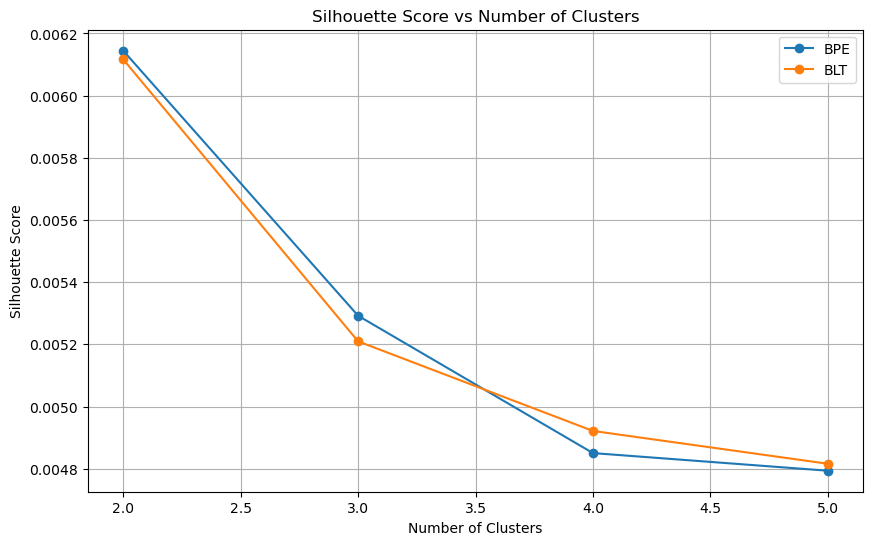

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

# Get embeddings from DuckDB
query = """
SELECT 
    embedding_bpe::DOUBLE[] as bpe_embedding,
    embedding_blt::DOUBLE[] as blt_embedding
FROM embeddings
"""
results = con.execute(query).fetchdf()

# Convert to numpy arrays
bpe_vectors = np.stack(results['bpe_embedding'].values)
blt_vectors = np.stack(results['blt_embedding'].values)

# Initialize KMeans
kmeans = KMeans(n_clusters=2, random_state=42)

# For BPE embeddings
cluster_labels_bpe = kmeans.fit_predict(bpe_vectors)
sil_score_bpe = silhouette_score(bpe_vectors, cluster_labels_bpe)

# For BLT embeddings
cluster_labels_blt = kmeans.fit_predict(blt_vectors)
sil_score_blt = silhouette_score(blt_vectors, cluster_labels_blt)

print(f"BPE Embeddings Silhouette Score: {sil_score_bpe:.4f}")
print(f"BLT Embeddings Silhouette Score: {sil_score_blt:.4f}")

# Optional: Try different numbers of clusters
n_clusters_range = range(2, 6)
scores_bpe = []
scores_blt = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # BPE
    labels_bpe = kmeans.fit_predict(bpe_vectors)
    scores_bpe.append(silhouette_score(bpe_vectors, labels_bpe))
    
    # BLT
    labels_blt = kmeans.fit_predict(blt_vectors)
    scores_blt.append(silhouette_score(blt_vectors, labels_blt))

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(list(n_clusters_range), scores_bpe, 'o-', label='BPE')
plt.plot(list(n_clusters_range), scores_blt, 'o-', label='BLT')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.legend()
plt.grid(True)
plt.show()

Result: there isn't a huge difference between BPE and BLT embeddings here. Slightly better at high cluster scores.

## Cosine Similarity distribution

Processing embeddings:   0%|          | 0/13455 [00:00<?, ?it/s]

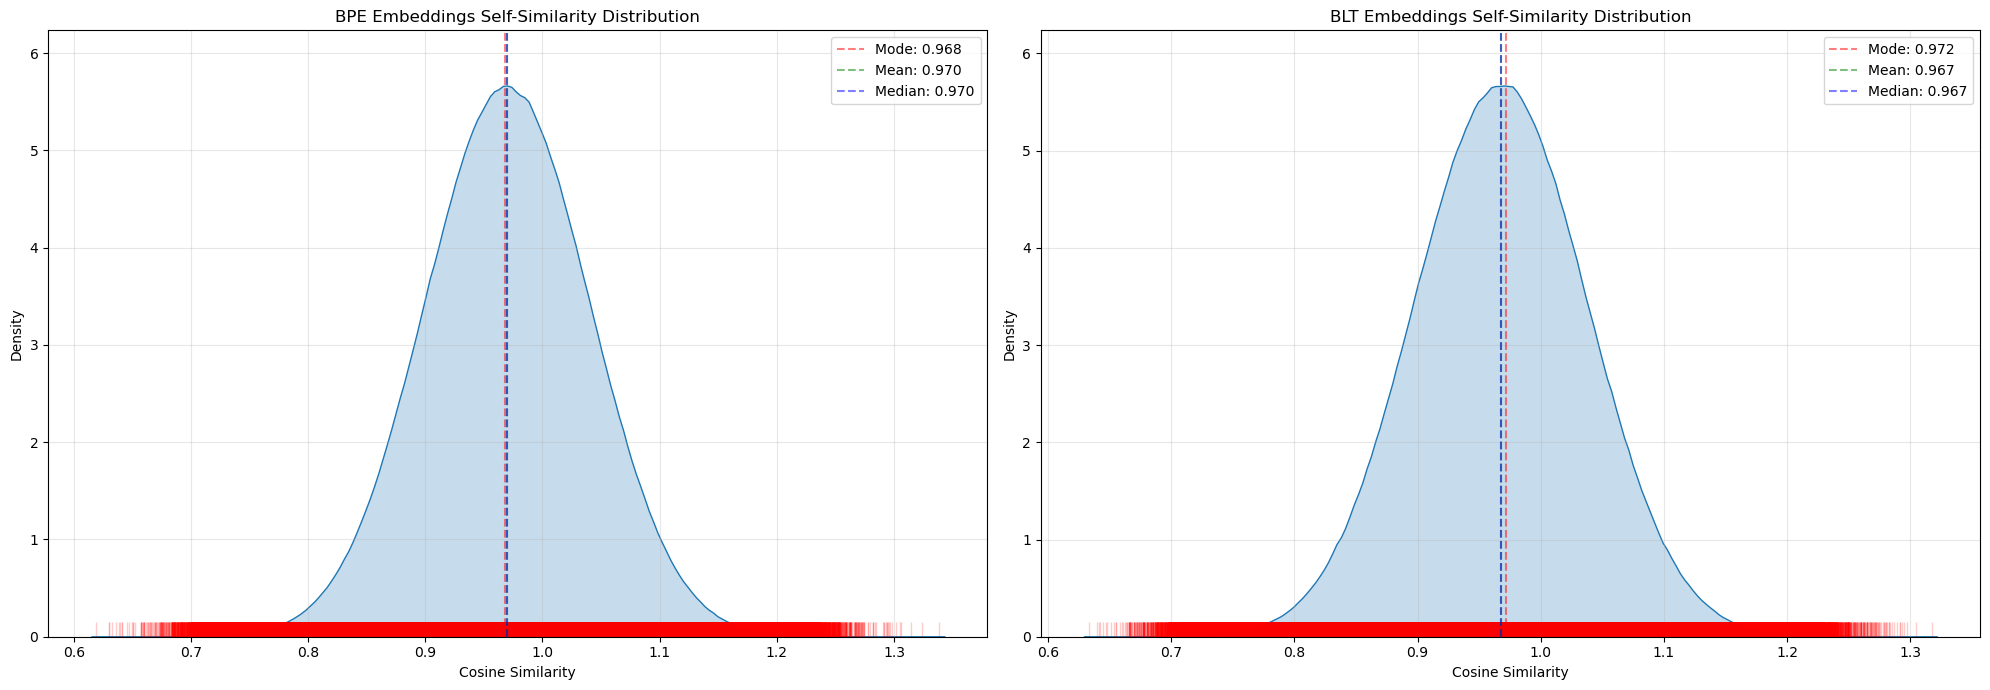


BPE Embeddings Distribution Statistics:
Number of samples: 6596785
Mean: 0.9697
Median: 0.9697
Mode (KDE peak): 0.9680
Standard deviation: 0.0701
25th percentile: 0.9222
75th percentile: 1.0171

BLT Embeddings Distribution Statistics:
Number of samples: 6596785
Mean: 0.9674
Median: 0.9674
Mode (KDE peak): 0.9719
Standard deviation: 0.0699
25th percentile: 0.9200
75th percentile: 1.0146


In [3]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# First, get the total count of rows to calculate expected comparisons
count_query = "SELECT COUNT(*) as cnt FROM embeddings"
total_rows = con.execute(count_query).fetchone()[0]
total_comparisons = (total_rows * (total_rows - 1)) // 2

# Modified queries with LIMIT and OFFSET for batch processing
base_query_template = """
WITH numbered_rows AS (
    SELECT 
        ROW_NUMBER() OVER () as row_id,
        embedding_{type}::DOUBLE[] as embedding
    FROM embeddings
    LIMIT {limit} OFFSET {offset}
)
SELECT 
    a.row_id as id1,
    b.row_id as id2,
    (a.embedding <=> b.embedding) as cosine_similarity
FROM numbered_rows a
CROSS JOIN numbered_rows b
WHERE a.row_id < b.row_id
"""

batch_size = 1000
bpe_similarities = []
blt_similarities = []

# Process in batches with progress bar
with tqdm(total=total_rows, desc="Processing embeddings") as pbar:
    for offset in range(0, total_rows, batch_size):
        # Process BPE embeddings
        bpe_query = base_query_template.format(
            type='bpe',
            limit=batch_size,
            offset=offset
        )
        bpe_batch = con.execute(bpe_query).fetchnumpy()['cosine_similarity']
        bpe_similarities.extend(bpe_batch)
        
        # Process BLT embeddings
        blt_query = base_query_template.format(
            type='blt',
            limit=batch_size,
            offset=offset
        )
        blt_batch = con.execute(blt_query).fetchnumpy()['cosine_similarity']
        blt_similarities.extend(blt_batch)
        
        pbar.update(batch_size)

# Convert to numpy arrays
bpe_similarities = np.array(bpe_similarities)
blt_similarities = np.array(blt_similarities)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# Plot BPE similarities
sns.kdeplot(data=bpe_similarities, fill=True, bw_adjust=0.5, ax=ax1)
sns.rugplot(data=bpe_similarities, color='red', alpha=0.2, ax=ax1)

# Calculate and plot BPE statistics
kde_bpe = stats.gaussian_kde(bpe_similarities)
x_eval_bpe = np.linspace(bpe_similarities.min(), bpe_similarities.max(), 100)
kde_values_bpe = kde_bpe(x_eval_bpe)
mode_idx_bpe = np.argmax(kde_values_bpe)
mode_value_bpe = x_eval_bpe[mode_idx_bpe]

ax1.axvline(x=mode_value_bpe, color='red', linestyle='--', alpha=0.5, label=f'Mode: {mode_value_bpe:.3f}')
ax1.axvline(x=np.mean(bpe_similarities), color='green', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(bpe_similarities):.3f}')
ax1.axvline(x=np.median(bpe_similarities), color='blue', linestyle='--', alpha=0.5, label=f'Median: {np.median(bpe_similarities):.3f}')

ax1.set_title('BPE Embeddings Self-Similarity Distribution')
ax1.set_xlabel('Cosine Similarity')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot BLT similarities
sns.kdeplot(data=blt_similarities, fill=True, bw_adjust=0.5, ax=ax2)
sns.rugplot(data=blt_similarities, color='red', alpha=0.2, ax=ax2)

# Calculate and plot BLT statistics
kde_blt = stats.gaussian_kde(blt_similarities)
x_eval_blt = np.linspace(blt_similarities.min(), blt_similarities.max(), 100)
kde_values_blt = kde_blt(x_eval_blt)
mode_idx_blt = np.argmax(kde_values_blt)
mode_value_blt = x_eval_blt[mode_idx_blt]

ax2.axvline(x=mode_value_blt, color='red', linestyle='--', alpha=0.5, label=f'Mode: {mode_value_blt:.3f}')
ax2.axvline(x=np.mean(blt_similarities), color='green', linestyle='--', alpha=0.5, label=f'Mean: {np.mean(blt_similarities):.3f}')
ax2.axvline(x=np.median(blt_similarities), color='blue', linestyle='--', alpha=0.5, label=f'Median: {np.median(blt_similarities):.3f}')

ax2.set_title('BLT Embeddings Self-Similarity Distribution')
ax2.set_xlabel('Cosine Similarity')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics for both distributions
print("\nBPE Embeddings Distribution Statistics:")
print(f"Number of samples: {len(bpe_similarities)}")
print(f"Mean: {np.mean(bpe_similarities):.4f}")
print(f"Median: {np.median(bpe_similarities):.4f}")
print(f"Mode (KDE peak): {mode_value_bpe:.4f}")
print(f"Standard deviation: {np.std(bpe_similarities):.4f}")
print(f"25th percentile: {np.percentile(bpe_similarities, 25):.4f}")
print(f"75th percentile: {np.percentile(bpe_similarities, 75):.4f}")

print("\nBLT Embeddings Distribution Statistics:")
print(f"Number of samples: {len(blt_similarities)}")
print(f"Mean: {np.mean(blt_similarities):.4f}")
print(f"Median: {np.median(blt_similarities):.4f}")
print(f"Mode (KDE peak): {mode_value_blt:.4f}")
print(f"Standard deviation: {np.std(blt_similarities):.4f}")
print(f"25th percentile: {np.percentile(blt_similarities, 25):.4f}")
print(f"75th percentile: {np.percentile(blt_similarities, 75):.4f}")

We want a good distribution to be able to train classifiers here. BPE appears to slightly better, because the distribution range is bigger. But this is microscopic, so we can't really tell.

## Clustering test

Can we cluster the embeddings? Has a semantic / meaningful structure been retained or do we see information loss?

Deep Learning suffers from the curse of dimensionality. Here we can use UMAP to visualize the embeddings. If possible, the dataset shouldn't appear to be scattered  like rain in an Anime, but grouped as a cluster of distinguished feature points.

In [ ]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Fetch vectors
query_bpe = "SELECT embedding_bpe::DOUBLE[] FROM embeddings"
query_blt = "SELECT embedding_blt::DOUBLE[] FROM embeddings"

bpe_vectors = np.array([vec for vec in con.execute(query_bpe).fetchnumpy()['CAST(embedding_bpe AS DOUBLE[])']])
blt_vectors = np.array([vec for vec in con.execute(query_blt).fetchnumpy()['CAST(embedding_blt AS DOUBLE[])']])

# Preprocess: Standardize the vectors
scaler = StandardScaler()
bpe_vectors_scaled = scaler.fit_transform(bpe_vectors)
blt_vectors_scaled = scaler.fit_transform(blt_vectors)

# Configure UMAP for better clustering
umap_config = {
    'n_neighbors': 30,        # Higher number = more global structure
    'min_dist': 0.1,         # Lower number = tighter clusters
    'n_components': 2,
    'metric': 'cosine',      # Use cosine distance since we're dealing with embeddings
    'random_state': 42,      # For reproducibility
    'n_jobs': -1,           # Use all CPU cores
}

# Create UMAP reducers
umap_reducer_bpe = umap.UMAP(**umap_config)
umap_reducer_blt = umap.UMAP(**umap_config)

# Fit and transform
umap_results_bpe = umap_reducer_bpe.fit_transform(bpe_vectors_scaled)
umap_results_blt = umap_reducer_blt.fit_transform(blt_vectors_scaled)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Function to create enhanced scatter plots
def plot_umap(ax, data, title):
    scatter = ax.scatter(
        data[:, 0], 
        data[:, 1],
        s=3,                    # Smaller points
        alpha=0.6,              # Transparency
        c=data[:, 0],          # Color by first component
        cmap='viridis',        # Color scheme
    )
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel('UMAP component 1', fontsize=12)
    ax.set_ylabel('UMAP component 2', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    fig.colorbar(scatter, ax=ax, label='Component 1 value')

# Plot results
plot_umap(ax1, umap_results_bpe, 'UMAP Visualization of BPE Vectors\n(cosine metric, normalized)')
plot_umap(ax2, umap_results_blt, 'UMAP Visualization of BLT Vectors\n(cosine metric, normalized)')

# Adjust layout
plt.tight_layout()
plt.show()

# Print some statistics about the embeddings distribution
for name, vectors in [('BPE', bpe_vectors), ('BLT', blt_vectors)]:
    print(f"\n{name} Embeddings Statistics:")
    norms = np.linalg.norm(vectors, axis=1)
    print(f"Mean vector norm: {norms.mean():.4f}")
    print(f"Std vector norm: {norms.std():.4f}")
    print(f"Min vector norm: {norms.min():.4f}")
    print(f"Max vector norm: {norms.max():.4f}")

c:\Users\mariu\anaconda3\envs\log2ml\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\mariu\anaconda3\envs\log2ml\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


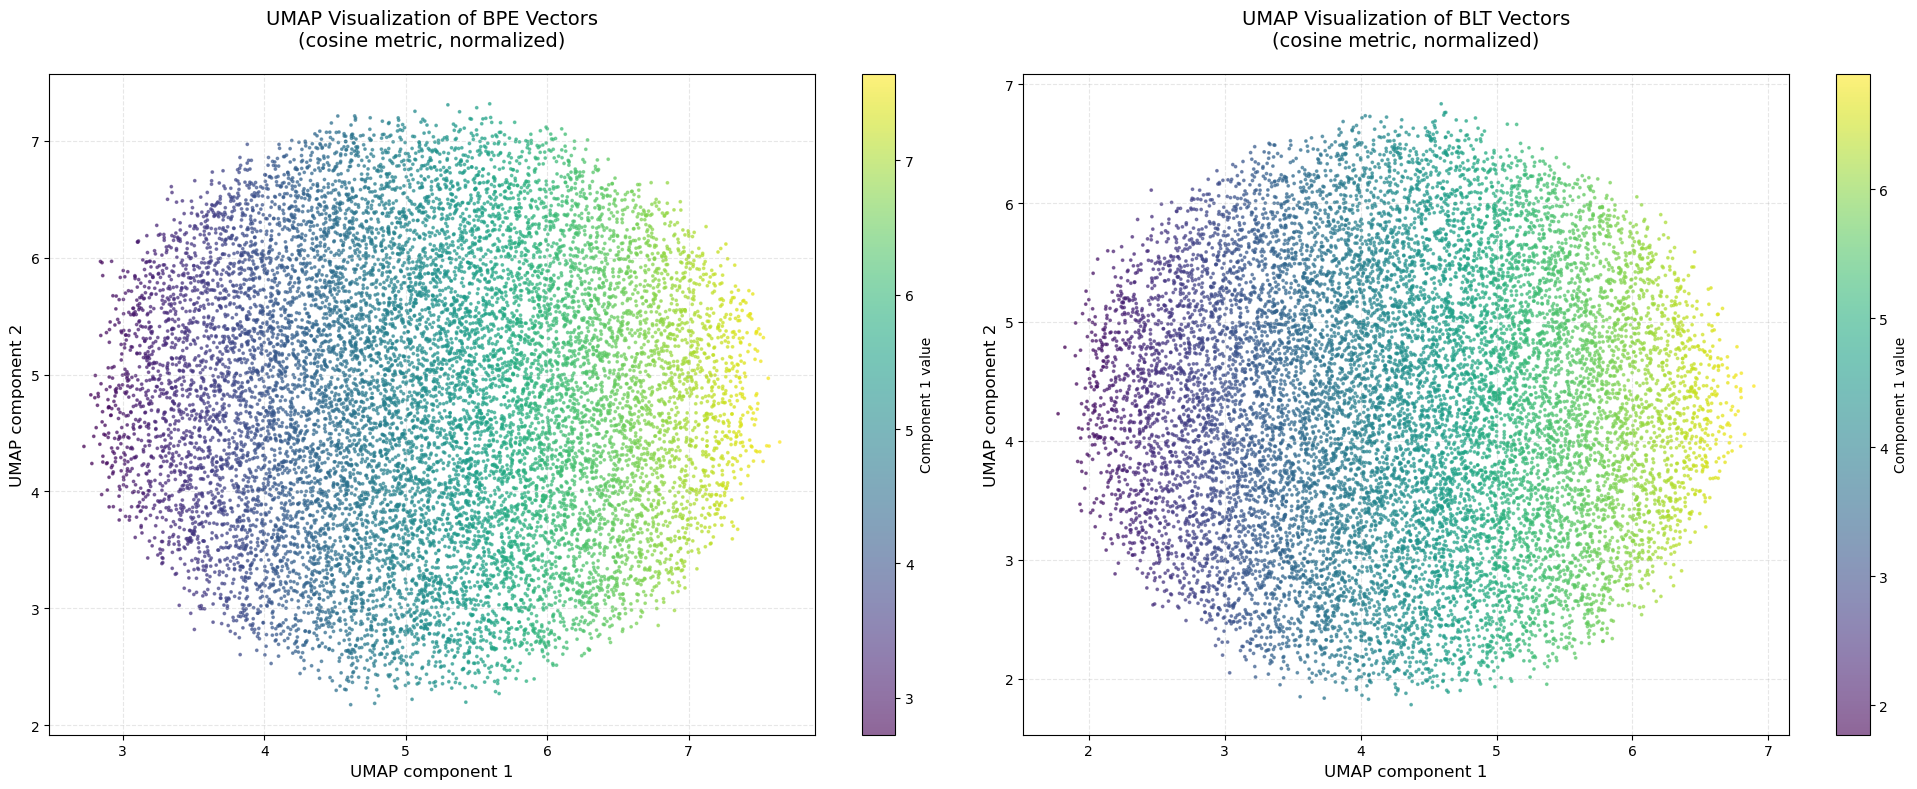


BPE Embeddings Statistics:
Mean vector norm: 18.0688
Std vector norm: 0.8002
Min vector norm: 14.9013
Max vector norm: 24.4793

BLT Embeddings Statistics:
Mean vector norm: 18.3255
Std vector norm: 0.9138
Min vector norm: 15.4433
Max vector norm: 45.8856


In [2]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

# Fetch vectors
query_bpe = "SELECT embedding_bpe::DOUBLE[] FROM embeddings"
query_blt = "SELECT embedding_blt::DOUBLE[] FROM embeddings"

bpe_vectors = np.array([vec for vec in con.execute(query_bpe).fetchnumpy()['CAST(embedding_bpe AS DOUBLE[])']])
blt_vectors = np.array([vec for vec in con.execute(query_blt).fetchnumpy()['CAST(embedding_blt AS DOUBLE[])']])

# Preprocess: Standardize the vectors
scaler = StandardScaler()
bpe_vectors_scaled = scaler.fit_transform(bpe_vectors)
blt_vectors_scaled = scaler.fit_transform(blt_vectors)

# Configure UMAP for better clustering
umap_config = {
    'n_neighbors': 30,        # Higher number = more global structure
    'min_dist': 0.1,         # Lower number = tighter clusters
    'n_components': 2,
    'metric': 'cosine',      # Use cosine distance since we're dealing with embeddings
    'random_state': 42,      # For reproducibility
    'n_jobs': -1,           # Use all CPU cores
}

# Create UMAP reducers
umap_reducer_bpe = umap.UMAP(**umap_config)
umap_reducer_blt = umap.UMAP(**umap_config)

# Fit and transform
umap_results_bpe = umap_reducer_bpe.fit_transform(bpe_vectors_scaled)
umap_results_blt = umap_reducer_blt.fit_transform(blt_vectors_scaled)

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Function to create enhanced scatter plots
def plot_umap(ax, data, title):
    scatter = ax.scatter(
        data[:, 0], 
        data[:, 1],
        s=3,                    # Smaller points
        alpha=0.6,              # Transparency
        c=data[:, 0],          # Color by first component
        cmap='viridis',        # Color scheme
    )
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel('UMAP component 1', fontsize=12)
    ax.set_ylabel('UMAP component 2', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.3)
    fig.colorbar(scatter, ax=ax, label='Component 1 value')

# Plot results
plot_umap(ax1, umap_results_bpe, 'UMAP Visualization of BPE Vectors\n(cosine metric, normalized)')
plot_umap(ax2, umap_results_blt, 'UMAP Visualization of BLT Vectors\n(cosine metric, normalized)')

# Adjust layout
plt.tight_layout()
plt.show()

# Print some statistics about the embeddings distribution
for name, vectors in [('BPE', bpe_vectors), ('BLT', blt_vectors)]:
    print(f"\n{name} Embeddings Statistics:")
    norms = np.linalg.norm(vectors, axis=1)
    print(f"Mean vector norm: {norms.mean():.4f}")
    print(f"Std vector norm: {norms.std():.4f}")
    print(f"Min vector norm: {norms.min():.4f}")
    print(f"Max vector norm: {norms.max():.4f}")

The smooth, continuous distribution in UMAP (rather than distinct clusters) combined with the very even distribution of variance in PCA suggests that:

- The Embeddings are capturing continuous semantic relationships
- Each dimension contributes meaningfully to the overall representation

There's no "wasted" or redundant dimensions

This is actually desirable for log message embeddings because:

- Log messages exist on a continuous spectrum of meaning
- Similar logs should have similar but not identical embeddings
- The gradual color transition in UMAP shows smooth semantic transitions

If we had seen distinct clusters, it might have indicated:

- Over-simplification of the semantic space
- The model learning only categorical features
- Potential loss of nuanced differences between logs


The similarity between BPE and BLT visualizations also validates that:

- Both tokenization approaches are capturing similar semantic structures
- The choice of tokenization method isn't introducing significant bias
- The embedding space is being used similarly in both cases

## Principal Component Analysis

The Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space while preserving the most important information.

We use this as a further assessment of the Embeddings.

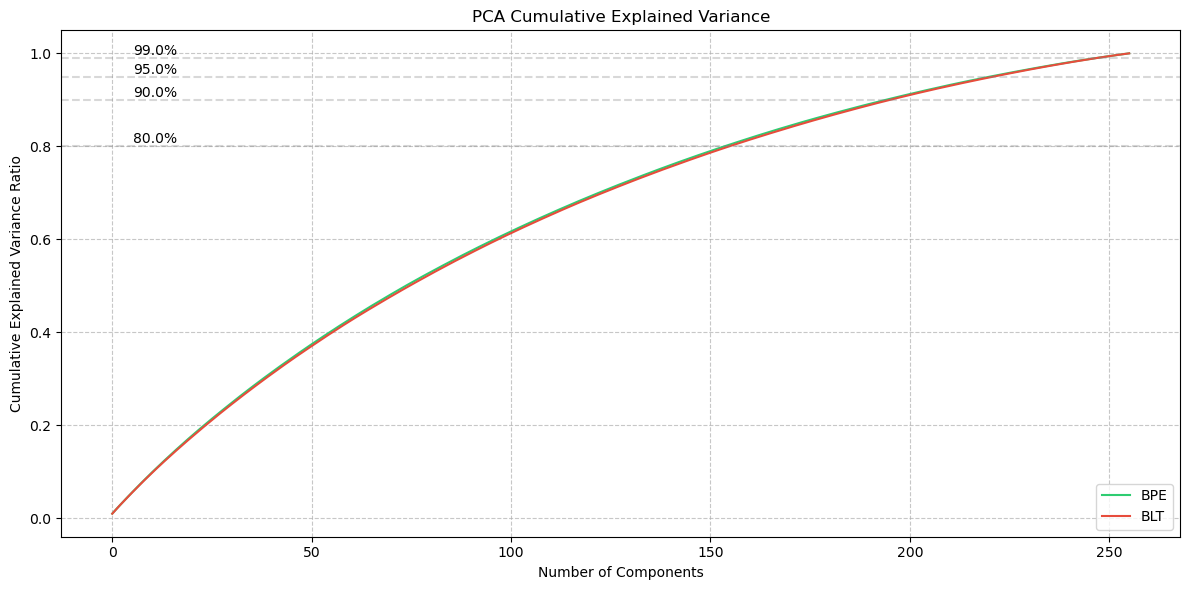


Number of components needed for variance thresholds:
Threshold  BPE        BLT       
------------------------------
 80%       155        156       
 90%       195        197       
 95%       222        222       
 99%       248        248       

Top 10 components' explained variance:
Component  BPE        BLT       
------------------------------
1          0.0098    0.0096
2          0.0096    0.0095
3          0.0093    0.0094
4          0.0091    0.0090
5          0.0091    0.0089
6          0.0089    0.0088
7          0.0088    0.0087
8          0.0087    0.0087
9          0.0086    0.0085
10         0.0085    0.0083

Total dimensions:
BPE: 256
BLT: 256


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Fetch vectors
query_bpe = "SELECT embedding_bpe::DOUBLE[] FROM embeddings"
query_blt = "SELECT embedding_blt::DOUBLE[] FROM embeddings"

bpe_vectors = np.array([vec for vec in con.execute(query_bpe).fetchnumpy()['CAST(embedding_bpe AS DOUBLE[])']])
blt_vectors = np.array([vec for vec in con.execute(query_blt).fetchnumpy()['CAST(embedding_blt AS DOUBLE[])']])

# Standardize the vectors
scaler = StandardScaler()
bpe_scaled = scaler.fit_transform(bpe_vectors)
blt_scaled = scaler.fit_transform(blt_vectors)

# Fit PCA for both
pca_bpe = PCA()
pca_blt = PCA()

pca_bpe.fit(bpe_scaled)
pca_blt.fit(blt_scaled)

# Calculate cumulative explained variance
cum_var_bpe = np.cumsum(pca_bpe.explained_variance_ratio_)
cum_var_blt = np.cumsum(pca_blt.explained_variance_ratio_)

# Find number of components needed for different variance thresholds
thresholds = [0.8, 0.9, 0.95, 0.99]
components_needed = {
    'BPE': [np.argmax(cum_var_bpe >= t) + 1 for t in thresholds],
    'BLT': [np.argmax(cum_var_blt >= t) + 1 for t in thresholds]
}

# Plot cumulative explained variance
plt.figure(figsize=(12, 6))
plt.plot(cum_var_bpe, label='BPE', color='#2ecc71')
plt.plot(cum_var_blt, label='BLT', color='#e74c3c')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Add horizontal lines for thresholds
for threshold in thresholds:
    plt.axhline(y=threshold, color='gray', linestyle='--', alpha=0.3)
    plt.text(len(cum_var_bpe) * 0.02, threshold, f'{threshold*100}%', 
             verticalalignment='bottom')

plt.tight_layout()
plt.show()

# Print detailed comparison
print("\nNumber of components needed for variance thresholds:")
print(f"{'Threshold':<10} {'BPE':<10} {'BLT':<10}")
print("-" * 30)
for threshold, bpe_n, blt_n in zip(thresholds, components_needed['BPE'], components_needed['BLT']):
    print(f"{threshold*100:>3.0f}%{' '*6} {bpe_n:<10} {blt_n:<10}")

# Print top 10 components' individual explained variance
print("\nTop 10 components' explained variance:")
print(f"{'Component':<10} {'BPE':<10} {'BLT':<10}")
print("-" * 30)
for i in range(10):
    print(f"{i+1:<10} {pca_bpe.explained_variance_ratio_[i]:.4f}    {pca_blt.explained_variance_ratio_[i]:.4f}")

# Print total dimensions
print(f"\nTotal dimensions:")
print(f"BPE: {bpe_vectors.shape[1]}")
print(f"BLT: {blt_vectors.shape[1]}")

### Information Distribution:

Both BPE and BLT embeddings use their dimensions very similarly (almost identical curves)

The variance is very evenly distributed across components (each of top 10 components explains ~0.9% of variance)
We need about 155-156 dimensions to capture 80% of the variance


### Dimensionality Assessment:

The fact that you need many dimensions (222 for 95% variance) suggests that your embeddings are efficiently using the space

There's no clear "elbow" in the curve, indicating that the information is distributed quite uniformly
This is actually a good sign for embeddings, as it suggests they're capturing different aspects of the data


### Why This is Good:
If weu had very few components explaining most variance, it would suggest potential underfitting
The uniform distribution suggests your model is learning diverse features
The similarity between BPE and BLT suggests both approaches are equally effective at capturing information

## Summary

**The UMAP visualization and the PCA analysis actually tell a consistent story** 

Both options are totally valid.

The choice between BPE and BLT is a matter of preference and the choice depends on the specific use case. Especially when it comes to logs, which isn't super valueable data per se.

## Comparison of BPE and BLT Embeddings Cosine Similarity Distribution with Standard Scaling or with Quantile Transformation 

The following code uses DuckDB to retrieve two Embeddings from the DuckDB database, transfers them to the GPU, and then compares the Cosine Similarity distribution between the original Embeddings, the Embeddings after standard scaling, and the Embeddings after quantile transformation.

This uses *cupy* which is like *numpy* but for GPU. The plotting still uses the CPU, so there is a bottleneck.

The GPU version is about 10x faster than the CPU version. :) 

GPU initialized successfully
Calculating similarities on GPU...
Processing 13455 vectors
Processing original bpe vectors on GPU...


Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Processing standardized bpe vectors...


Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Processing quantile transformed bpe vectors...


Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Processing 13455 vectors
Processing original blt vectors on GPU...


Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Processing standardized blt vectors...


Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Processing quantile transformed blt vectors...


Computing similarities:   0%|          | 0/14 [00:00<?, ?it/s]

Plotting distributions...


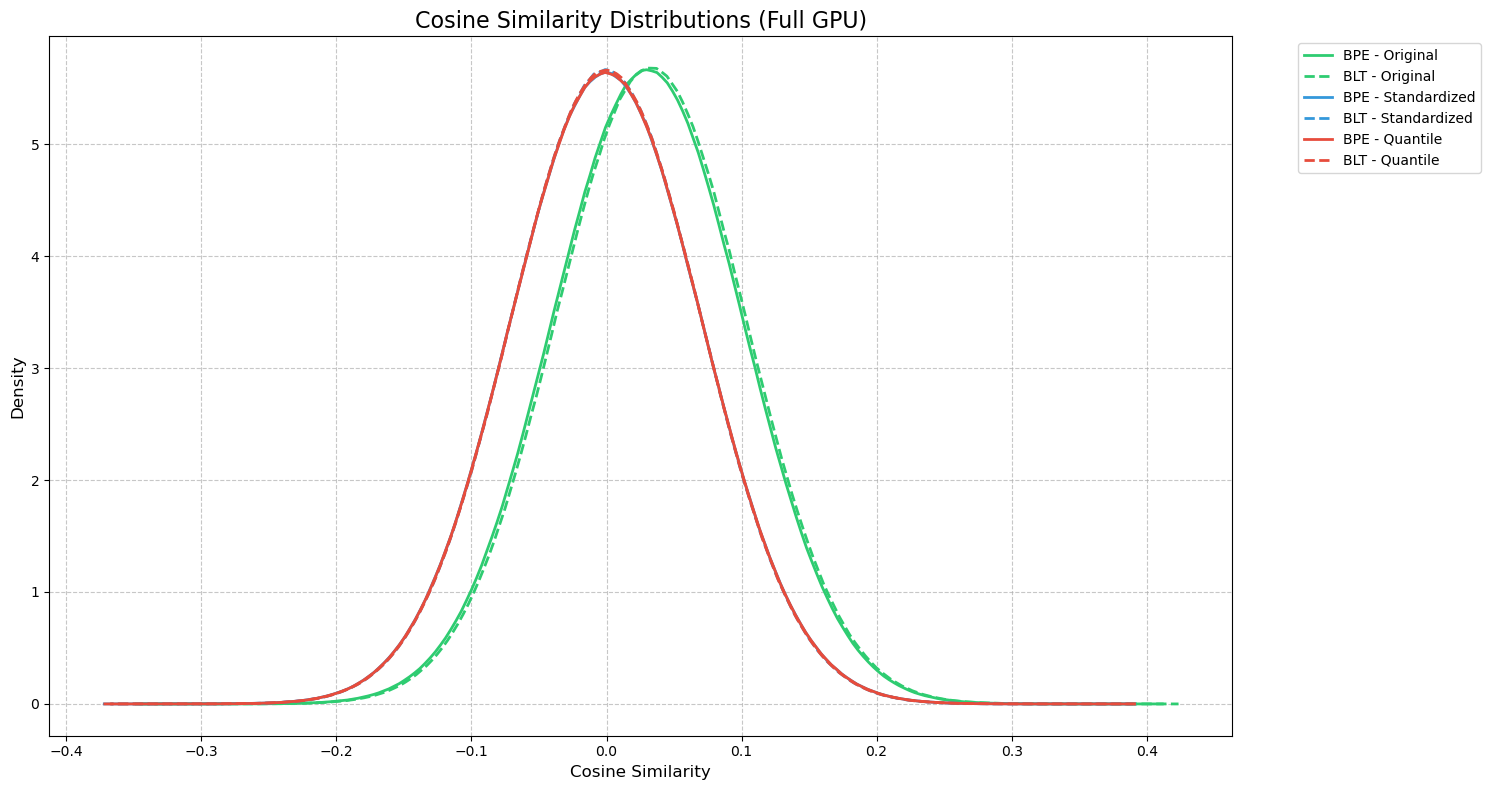


Calculating statistics...

BPE - Original Statistics:
Mean: 0.0303
Std: 0.0701
Min: -0.3482
Max: 0.4115
Total pairs: 90511785

BLT - Original Statistics:
Mean: 0.0327
Std: 0.0699
Min: -0.3457
Max: 0.4235
Total pairs: 90511785

BPE - Standardized Statistics:
Mean: -0.0001
Std: 0.0704
Min: -0.3657
Max: 0.3912
Total pairs: 90511785

BLT - Standardized Statistics:
Mean: -0.0001
Std: 0.0702
Min: -0.3729
Max: 0.3898
Total pairs: 90511785

BPE - Quantile Statistics:
Mean: -0.0000
Std: 0.0704
Min: -0.3666
Max: 0.3908
Total pairs: 90511785

BLT - Quantile Statistics:
Mean: -0.0000
Std: 0.0701
Min: -0.3725
Max: 0.3918
Total pairs: 90511785


In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from tqdm.notebook import tqdm

def kde_gpu(data_gpu, bw_adjust=0.5, grid_points=200):
    """Custom KDE implementation using GPU"""
    # Get min and max for the grid
    data_min = float(cp.min(data_gpu))
    data_max = float(cp.max(data_gpu))
    
    # Create evaluation grid
    x_grid = cp.linspace(data_min, data_max, grid_points)
    
    # Calculate bandwidth (Scott's rule)
    n = len(data_gpu)
    bandwidth = bw_adjust * cp.std(data_gpu) * (n ** (-1/5))
    
    # Compute KDE on GPU
    kde_values = cp.zeros_like(x_grid)
    
    # Vectorized KDE computation
    for i in range(0, len(data_gpu), 1000):  # Process in chunks to avoid memory issues
        batch = data_gpu[i:i+1000]
        diff = x_grid[:, None] - batch[None, :]
        kernel = cp.exp(-0.5 * (diff / bandwidth) ** 2)
        kde_values += cp.sum(kernel, axis=1)
    
    kde_values = kde_values / (n * bandwidth * cp.sqrt(2 * cp.pi))
    
    return cp.asnumpy(x_grid), cp.asnumpy(kde_values)

def get_cosine_similarities_gpu_batched(vectors_gpu, batch_size=1000):
    """Calculate pairwise cosine similarities using GPU in batches"""
    n_vectors = len(vectors_gpu)
    
    # Normalize vectors
    norms = cp.linalg.norm(vectors_gpu, axis=1)
    normalized = vectors_gpu / norms[:, cp.newaxis]
    
    similarities_gpu = cp.empty((n_vectors * (n_vectors - 1)) // 2, dtype=cp.float32)
    current_idx = 0
    
    # Process in batches
    for i in tqdm(range(0, n_vectors, batch_size), desc="Computing similarities"):
        end_idx = min(i + batch_size, n_vectors)
        # Calculate similarities for this batch
        batch_sims = cp.dot(normalized[i:end_idx], normalized.T)
        
        # Get upper triangle for this batch
        for j in range(i, end_idx):
            row_sims = batch_sims[j - i, (j + 1):]
            if len(row_sims) > 0:
                chunk_size = len(row_sims)
                similarities_gpu[current_idx:current_idx + chunk_size] = row_sims
                current_idx += chunk_size
        
        # Clear batch memory
        batch_sims = None
        cp.get_default_memory_pool().free_all_blocks()
    
    return similarities_gpu[:current_idx]

def get_transformed_similarities_gpu(embedding_type):
    # Get vectors from database
    query = f"SELECT embedding_{embedding_type}::DOUBLE[] FROM embeddings"
    result = con.execute(query).fetchnumpy()
    vectors_cpu = np.array([vec for vec in result[f'CAST(embedding_{embedding_type} AS DOUBLE[])']])
    print(f"Processing {len(vectors_cpu)} vectors")
    
    # Transfer to GPU
    vectors_gpu = cp.array(vectors_cpu)
    
    # Calculate similarities for original vectors
    print(f"Processing original {embedding_type} vectors on GPU...")
    sims_original = get_cosine_similarities_gpu_batched(vectors_gpu)
    
    # StandardScaler transformation
    print(f"Processing standardized {embedding_type} vectors...")
    scaler = StandardScaler()
    vectors_scaled_cpu = scaler.fit_transform(vectors_cpu)
    vectors_scaled_gpu = cp.array(vectors_scaled_cpu)
    sims_scaled = get_cosine_similarities_gpu_batched(vectors_scaled_gpu)
    
    # QuantileTransformer transformation
    print(f"Processing quantile transformed {embedding_type} vectors...")
    quantile = QuantileTransformer(output_distribution='normal')
    vectors_quantile_cpu = quantile.fit_transform(vectors_cpu)
    vectors_quantile_gpu = cp.array(vectors_quantile_cpu)
    sims_quantile = get_cosine_similarities_gpu_batched(vectors_quantile_gpu)
    
    # Clear GPU memory
    vectors_gpu = vectors_scaled_gpu = vectors_quantile_gpu = None
    cp.get_default_memory_pool().free_all_blocks()
    
    return sims_original, sims_scaled, sims_quantile

try:
    # Initialize GPU memory
    cp.cuda.runtime.setDevice(0)
    print("GPU initialized successfully")
    
    # Get similarities for both embedding types
    print("Calculating similarities on GPU...")
    bpe_sims = get_transformed_similarities_gpu('bpe')
    blt_sims = get_transformed_similarities_gpu('blt')
    
    # Plot distributions using GPU KDE
    plt.figure(figsize=(15, 8))
    colors = ['#2ecc71', '#3498db', '#e74c3c']
    labels = ['Original', 'Standardized', 'Quantile']
    
    print("Plotting distributions...")
    for i, (bpe_sim, blt_sim) in enumerate(zip(bpe_sims, blt_sims)):
        # Compute KDE on GPU
        x_bpe, y_bpe = kde_gpu(bpe_sim, bw_adjust=0.5)
        x_blt, y_blt = kde_gpu(blt_sim, bw_adjust=0.5)
        
        # Plot
        plt.plot(x_bpe, y_bpe, color=colors[i], linestyle='-', 
                label=f'BPE - {labels[i]}', linewidth=2)
        plt.plot(x_blt, y_blt, color=colors[i], linestyle='--', 
                label=f'BLT - {labels[i]}', linewidth=2)
    
    plt.title('Cosine Similarity Distributions (Full GPU)', fontsize=16)
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Print statistics using GPU data
    print("\nCalculating statistics...")
    for i, label in enumerate(labels):
        for embed_type, sims in [('BPE', bpe_sims[i]), ('BLT', blt_sims[i])]:
            print(f"\n{embed_type} - {label} Statistics:")
            print(f"Mean: {float(cp.mean(sims)):.4f}")
            print(f"Std: {float(cp.std(sims)):.4f}")
            print(f"Min: {float(cp.min(sims)):.4f}")
            print(f"Max: {float(cp.max(sims)):.4f}")
            print(f"Total pairs: {len(sims)}")

except ImportError:
    print("CuPy not installed. Please install it with:")
    print("pip install cupy-cuda11x  # Replace with your CUDA version")
except cp.cuda.runtime.CUDARuntimeError:
    print("No GPU available. Falling back to CPU version...")

## BLT (dashed lines) shows:
Slightly more consistent distribution across transformations
Marginally better spread in the positive similarity region
More stable behavior across different preprocessing methods

## BPE (solid lines) shows:

Very similar overall pattern
Slightly more variable behavior across transformations
Marginally narrower spread in some regions

BLT remains a little more consistent across various preprocessing methods. There are scale-sensitive and quantile-sensitive patterns, but in general, BLT is more consistent. It depends on the model architecture and the data distribution, but in general, BLT is more consistent.

## Is Llama 3 much better here?

To be done.